# **8.2 Querying and Merging**

**Name**: Calingo, Christian Lei

**Section**: CPE22S3

**Course**: Computational Thinking with Python

**Course Code**: CPE311



---



---



In [11]:
import pandas as pd
weather = pd.read_csv('data/nyc_weather_2018.csv')
weather.head()


,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


# **Querying DataFrames**

**The query() method is an easier way of filtering based on some criteria. For example, we can use it to find all entries where snow was recorded:**

In [12]:
snow_data = weather.query('datatype == "SNOW" and value > 0')
snow_data.head()

,date,datatype,station,attributes,value
31,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1600",229.0
34,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0830",10.0
38,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0018,",,N,0910",46.0
45,2018-01-05T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0720",102.0
49,2018-01-05T00:00:00,SNOW,GHCND:US1NJBG0018,",,N,1230",183.0


Using .loc() to check if output is the same

In [13]:
snow_data2 = weather.loc[(weather["datatype"] == "SNOW") & (weather["value"] > 0)]
snow_data2.head()

#.loc() can give us the same output however it is easire to use .query()

,date,datatype,station,attributes,value
31,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1600",229.0
34,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0830",10.0
38,2018-01-04T00:00:00,SNOW,GHCND:US1NJBG0018,",,N,0910",46.0
45,2018-01-05T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0720",102.0
49,2018-01-05T00:00:00,SNOW,GHCND:US1NJBG0018,",,N,1230",183.0


**Equivalent to quering the data/weather.db SQLite database for SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0**

In [16]:
import sqlite3
with sqlite3.connect('data/weather.db') as connection:
  snow_data_from_db = pd.read_sql('SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0',connection)
snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

True

**This is also equivalent to creating Boolean masks:**

In [17]:
weather[(weather.datatype == 'SNOW') & (weather.value > 0)].equals(snow_data)

True

# **Merging DataFrames**

We have data for many different stations each day; however, we don't know what the stations are just their IDs. We can join the data in the data/weather_stations.csv file which contains information from the stations endpoint of the NCEI API. Consult the weather_data_collection.ipynb notebook to see how this was collected. It looks like this:

In [18]:
station_info = pd.read_csv('data/weather_stations.csv')
station_info.head()

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.064100,-73.577000,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.037788,-73.568176,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.921298,-74.001983,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.902694,-74.083358,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.914670,-73.977500,21.6


In [19]:
weather.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


**We can join our data by matching up the station_info.id column with the weather.station column. Before doing that though, let's see how many unique values we
have:**

In [20]:
station_info.id.describe()

count                   320
unique                  320
top       GHCND:US1CTFR0022
freq                      1
Name: id, dtype: object

**While station_info has one row per station, the weather dataframe has many entries per station. Notice it also has fewer uniques**

In [21]:
weather.station.describe()

#the count is different since I assigned the value of limit as 10 not 1000

count                  3650
unique                   14
top       GHCND:US1NJBG0017
freq                    576
Name: station, dtype: object

**When working with joins, it is important to keep an eye on the row count. Some join types will lead to data loss:**

In [22]:
station_info.shape[0], weather.shape[0]

#once again, the counts are different since I assigned different values on the previous activity
#instead of assigning the limit to 1000, I limited it to 10

(320, 3650)

**We will be doing this often, it makes more sense to write a function:**

In [24]:
def get_row_count(*dfs):
  return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)

[320, 3650]

**The map() function is more efficient than list comprehensions. We can couple this with getattr() to grab any attribute for multiple dataframes**

In [25]:
def get_info(attr, *dfs):
  return list(map(lambda x: getattr(x, attr), dfs))
get_info('shape', station_info, weather)

[(320, 5), (3650, 5)]

**By default merge() performs an inner join. We simply specify the columns to use for the join. The left dataframe is the one we call merge() on, and the right one is passed in as an argument**

In [26]:
inner_join = weather.merge(station_info, left_on='station', right_on='id')
inner_join.sample(5, random_state=0)

# the outputs might be differ in the module
# the reason might be the sudden change in the limit in the previous activity

,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
3516,2018-09-26T00:00:00,PRCP,GHCND:US1NJBG0010,",,N,0800",84.8,GHCND:US1NJBG0010,"RIVER VALE TWP 1.5 S, NJ US",40.991450,-74.012348,9.4
569,2018-05-23T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1120",17.0,GHCND:US1NJBG0015,"NORTH ARLINGTON 0.7 WNW, NJ US",40.791492,-74.139790,17.7
991,2018-02-28T00:00:00,DAPR,GHCND:US1NJBG0017,",,N,0750",8.0,GHCND:US1NJBG0017,"GLEN ROCK 0.7 SSE, NJ US",40.951090,-74.118264,28.0
2095,2018-02-22T00:00:00,SNOW,GHCND:US1NJBG0023,",,N,0800",0.0,GHCND:US1NJBG0023,"OAKLAND 0.9 SSE, NJ US",41.019050,-74.233383,149.4
2566,2018-08-22T00:00:00,PRCP,GHCND:US1NJBG0030,",,N,0700",21.1,GHCND:US1NJBG0030,"OAKLAND 1.0 ESE, NJ US",41.025324,-74.223632,109.4


**We can remove the duplication of information in the station and id columns by renaming one of them before the merge and then simply using on**

In [27]:
weather.merge(station_info.rename(dict(id='station'), axis=1), on='station').sample(5, random_state=0)

#since id and station have the same values, the id got merged with the station

,date,datatype,station,attributes,value,name,latitude,longitude,elevation
3516,2018-09-26T00:00:00,PRCP,GHCND:US1NJBG0010,",,N,0800",84.8,"RIVER VALE TWP 1.5 S, NJ US",40.991450,-74.012348,9.4
569,2018-05-23T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1120",17.0,"NORTH ARLINGTON 0.7 WNW, NJ US",40.791492,-74.139790,17.7
991,2018-02-28T00:00:00,DAPR,GHCND:US1NJBG0017,",,N,0750",8.0,"GLEN ROCK 0.7 SSE, NJ US",40.951090,-74.118264,28.0
2095,2018-02-22T00:00:00,SNOW,GHCND:US1NJBG0023,",,N,0800",0.0,"OAKLAND 0.9 SSE, NJ US",41.019050,-74.233383,149.4
2566,2018-08-22T00:00:00,PRCP,GHCND:US1NJBG0030,",,N,0700",21.1,"OAKLAND 1.0 ESE, NJ US",41.025324,-74.223632,109.4


**We are losing stations that don't have weather observations associated with them, if we don't want to lose these rows, we perform a right or left join instead of the inner join**

In [28]:
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')
right_join.tail()


,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation
3951,NaN,NaN,NaN,NaN,NaN,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",40.73443,-73.41637,22.8
3952,NaN,NaN,NaN,NaN,NaN,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7
3953,NaN,NaN,NaN,NaN,NaN,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",40.85898,-74.05616,0.8
3954,NaN,NaN,NaN,NaN,NaN,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",41.06236,-73.70454,112.9
3955,NaN,NaN,NaN,NaN,NaN,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.76390,2.7


**The left and right join as we performed above are equivalent because the side that we kept the rows without matches was the same in both cases**

In [29]:
left_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index').equals(
right_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index')
)

True

**Note we have additional rows in the left and right joins because we kept all the stations that didn't have weather observations**

In [30]:
get_info('shape', inner_join, left_join, right_join)

[(3650, 10), (3956, 10), (3956, 10)]

**If we query the station information for stations that have NY in their name, believing that to be all the stations that record weather data for NYC and perform an outer join, we can see where the mismatches occur:**

In [31]:
outer_join = weather.merge(
station_info[station_info.name.str.contains('NY')],
left_on='station', right_on='id', how='outer', indicator=True
)
outer_join.sample(4, random_state=0).append(outer_join[outer_join.station.isna()].head(2))

<ipython-input-31-81b63e73e04e>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outer_join.sample(4, random_state=0).append(outer_join[outer_join.station.isna()].head(2))


,date,datatype,station,attributes,value,id,name,latitude,longitude,elevation,_merge
538,2018-05-02T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,0815",0.0,NaN,NaN,NaN,NaN,NaN,left_only
526,2018-04-23T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1015",0.0,NaN,NaN,NaN,NaN,NaN,left_only
2215,2018-05-20T00:00:00,PRCP,GHCND:US1NJBG0023,",,N,0745",12.4,NaN,NaN,NaN,NaN,NaN,left_only
2872,2018-03-01T00:00:00,SNOW,GHCND:US1NJBG0003,",,N,0730",0.0,NaN,NaN,NaN,NaN,NaN,left_only
3650,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJHD0002,"KEARNY 1.7 NW, NJ US",40.772892,-74.140926,29.0,right_only
3651,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJHD0018,"KEARNY 1.7 NNW, NJ US",40.774342,-74.137109,25.6,right_only


**These joins are equivalent to their SQL counterparts. Below is the inner join. Note that to use equals() you will have to do some manipulation of the dataframes to line
them up**

In [33]:
import sqlite3
with sqlite3.connect('data/weather.db') as connection:
  inner_join_from_db = pd.read_sql('SELECT * FROM weather JOIN stations ON weather.station == stations.id',connection)
inner_join_from_db.shape == inner_join.shape

True

**Revisit the dirty data from the previous module**

In [36]:
dirty_data = pd.read_csv(
'data/dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


**We need to create two dataframes for the join. We will drop some unecessary columns as well for easier viewing**

In [37]:
valid_station = dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

**Our column for the join is the index in both dataframes, so we must specify left_index and right_index **

In [38]:
valid_station.merge(
station_with_wesf, left_index=True, right_index=True
).query('WESF > 0').head()

,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


**The columns that existed in both dataframes, but didn't form part of the join got suffixes added to their names: _x for columns from the left dataframe and _y for columns
from the right dataframe. We can customize this with the suffixes argument:**

In [39]:
valid_station.merge(
station_with_wesf, left_index=True, right_index=True, suffixes=('', '_?')
).query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


**Since we are joining on the index, an easier way is to use the join() method instead of merge() . Note that the suffix parameter is now lsuffix for the left dataframe's
suffix and rsuffix for the right one's**

In [40]:
valid_station.join(station_with_wesf, rsuffix='_?').query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


**Joins can be very resource-intensive, so it's a good idea to figure out what type of join you need using set operations before trying the join itself. The pandas set operations
are performed on the index, so whichever columns we will be joining on will need to be the index. Let's go back to the weather and station_info dataframes and set
the station ID columns as the index**

In [41]:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

**The intersection will tell us the stations that are present in both dataframes. The result will be the index when performing an inner join**

In [42]:
weather.index.intersection(station_info.index)


Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0044',
       'GHCND:US1NJES0018', 'GHCND:US1NJBG0010', 'GHCND:US1NJES0019',
       'GHCND:US1NJES0024', 'GHCND:US1NJBG0037'],
      dtype='object')

**The set difference will tell us what we lose from each side. When performing an inner join, we lose nothing from the weather dataframe**

In [43]:
weather.index.difference(station_info.index)

Index([], dtype='object')

**We lose 153 stations from the station_info dataframe, however**

In [44]:
station_info.index.difference(weather.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008',
       'GHCND:US1NJBG0011', 'GHCND:US1NJBG0012', 'GHCND:US1NJBG0013',
       'GHCND:US1NJBG0020',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=306)

**The symmetric difference will tell us what gets lost from both sides. It is the combination of the set difference in both directions**

In [45]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

True

**The union will show us everything that will be present after a full outer join. Note that since these are sets (which don't allow duplicates by definition), we must pass unique entries for union:**

In [46]:
weather.index.unique().union(station_info.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=320)

**Note that the symmetric difference is actually the union of the set differences**

In [47]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).union(weather.index.difference(ny_in_name.index)).equals(
weather.index.symmetric_difference(ny_in_name.index)
)

True



---



---


# **Conclusion**

In this activity, we performed different querying and merging of dataframes. Some of my outputs are not the same in the module because I tried changing the limit:

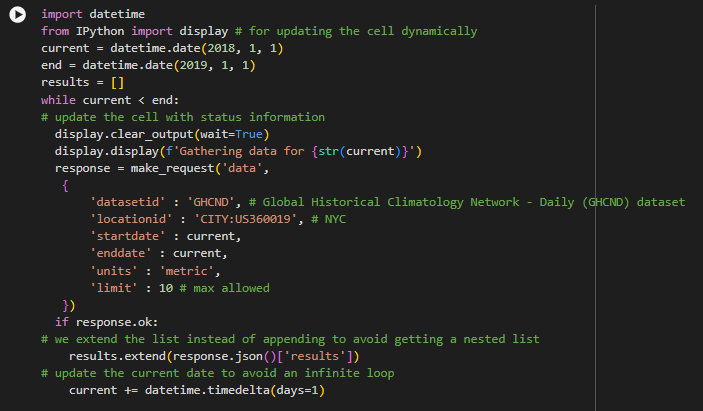

Instead of 1000, I used 10 for faster loading. You can merge diffrent dataframes in lots of ways and also merging columns of a dataframe is also possible. However, some conditions are required in order for it to work.